In [14]:
import matplotlib.pyplot as plt
import torch
from torchvision import datasets
from torch import nn
import torchvision
from tqdm.auto import tqdm
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report

In [15]:
train_d = datasets.FashionMNIST(root="data", 
                                train=True, 
                                download=True, 
                                transform = torchvision.transforms.ToTensor(), # Do you want to transform the data
                                target_transform = None # How do you want to transform the labels/targets
                                )

test_d = datasets.FashionMNIST(root="data", 
                                train=False, 
                                download=True, 
                                transform = torchvision.transforms.ToTensor(), # Do you want to transform the data
                                target_transform = None # How do you want to transform the labels/targets
                                )

c_names = train_d.classes 
c_to_idx = train_d.class_to_idx

image, label = train_d[0]

train_dload = DataLoader(dataset = train_d, batch_size = 32, shuffle = True)
test_dload = DataLoader(dataset = test_d, batch_size = 32, shuffle = False)


# image, label = test_d[0]

print(f"Image shape: {image.shape} -> Colour channels, Height, Width \n´Image label: {c_names[label]}")


Image shape: torch.Size([1, 28, 28]) -> Colour channels, Height, Width 
´Image label: Ankle boot


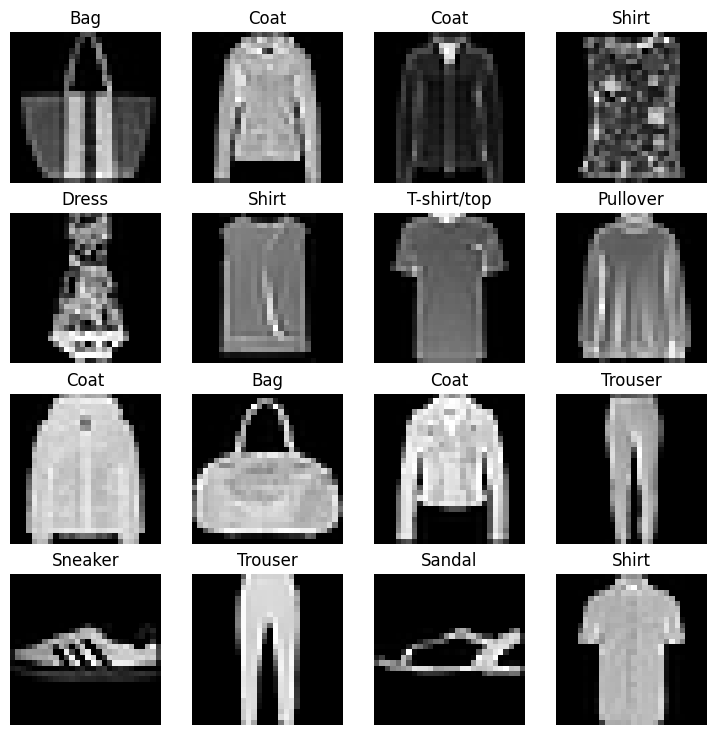

In [16]:
fig = plt.figure(figsize=(9,9))
rows, col = 4,4
for i in range(1, rows*col+1):
    rand_idx = torch.randint(0, len(train_d), size=[1]).item()
    img, label = train_d[rand_idx]
    fig.add_subplot(rows, col, i)
    plt.imshow(img.squeeze(), cmap="grey")
    plt.title(c_names[label])
    plt.axis(False)
plt.show()

In [17]:
class nn_model0(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        
        # Define your convolutional layers
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=hidden_units, kernel_size=2),  # Use in_channels=1 for grayscale images
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=2),
            nn.ReLU()
        )

        # Pass a dummy input to calculate the flattened size
        dummy_input = torch.randn(1, 1, 28, 28)  # Assuming the input images are 28x28
        dummy_output = self.conv_layers(dummy_input)
        flattened_size = dummy_output.view(-1).shape[0]  # Flatten and get the size

        # Define the fully connected layers with the correct flattened size
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=flattened_size, out_features=output_shape)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x


In [18]:
device = "cuda" if torch.cuda.is_available() else "cpu"

torch.manual_seed(42)
model0 = nn_model0(input_shape=1, hidden_units=10, output_shape=len(c_names))
model0 = model0.to(device)
loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.SGD(params=model0.parameters(), lr=0.1 )



In [19]:
# Lists to store training and validation metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in tqdm(range(300)):
    print(f"Epoch: {epoch+1}/{300}")
    
    # Training phase
    model0.train()
    train_loss = 0
    correct_train = 0
    total_train = 0
    
    for batch, (x, y) in enumerate(train_dload):
        x, y = x.to(device), y.to(device)
        
        # Forward pass
        y_pred = model0(x)
        
        # Compute the loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        
        # Zero out the gradients before the backward pass
        optim.zero_grad()
        
        # Backward pass
        loss.backward()
        
        # Update weights
        optim.step()

        # Calculate training accuracy
        _, predicted = torch.max(y_pred, 1)
        correct_train += (predicted == y).sum().item()
        total_train += y.size(0)
    
    # Calculate average training loss and accuracy
    avg_train_loss = train_loss / len(train_dload)
    train_accuracy = correct_train / total_train

    # Append the training metrics to the lists
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    # Validation phase
    model0.eval()
    val_loss = 0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for x_val, y_val in test_dload:
            x_val, y_val = x_val.to(device), y_val.to(device)
            
            # Forward pass
            y_val_pred = model0(x_val)
            
            # Compute the validation loss
            loss = loss_fn(y_val_pred, y_val)
            val_loss += loss.item()
            
            # Calculate validation accuracy
            _, predicted_val = torch.max(y_val_pred, 1)
            correct_val += (predicted_val == y_val).sum().item()
            total_val += y_val.size(0)
    
    # Calculate average validation loss and accuracy
    avg_val_loss = val_loss / len(test_dload)
    val_accuracy = correct_val / total_val

    # Append the validation metrics to the lists
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    # Print epoch statistics
    print(f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy*100:.2f}%")
    print(f"Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy*100:.2f}%\n---------------")


model_save_path = "model1.pth"  
torch.save(model0.state_dict(), model_save_path)


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 1/300


  0%|          | 1/300 [00:09<46:36,  9.35s/it]

Train Loss: 0.5303, Train Accuracy: 80.83%
Val Loss: 0.5017, Val Accuracy: 80.90%
---------------
Epoch: 2/300


  1%|          | 2/300 [00:17<44:23,  8.94s/it]

Train Loss: 0.3850, Train Accuracy: 86.08%
Val Loss: 0.3899, Val Accuracy: 86.31%
---------------
Epoch: 3/300


  1%|          | 3/300 [00:26<44:03,  8.90s/it]

Train Loss: 0.3525, Train Accuracy: 87.34%
Val Loss: 0.3584, Val Accuracy: 86.89%
---------------
Epoch: 4/300


  1%|▏         | 4/300 [00:35<43:19,  8.78s/it]

Train Loss: 0.3297, Train Accuracy: 88.11%
Val Loss: 0.3660, Val Accuracy: 86.65%
---------------
Epoch: 5/300


  2%|▏         | 5/300 [00:44<43:41,  8.89s/it]

Train Loss: 0.3102, Train Accuracy: 88.76%
Val Loss: 0.3266, Val Accuracy: 88.76%
---------------
Epoch: 6/300


  2%|▏         | 6/300 [00:53<44:08,  9.01s/it]

Train Loss: 0.2992, Train Accuracy: 89.26%
Val Loss: 0.3357, Val Accuracy: 88.16%
---------------
Epoch: 7/300


  2%|▏         | 7/300 [01:02<44:19,  9.08s/it]

Train Loss: 0.2888, Train Accuracy: 89.60%
Val Loss: 0.3251, Val Accuracy: 88.40%
---------------
Epoch: 8/300


  3%|▎         | 8/300 [01:12<44:34,  9.16s/it]

Train Loss: 0.2796, Train Accuracy: 89.90%
Val Loss: 0.3366, Val Accuracy: 87.80%
---------------
Epoch: 9/300


  3%|▎         | 9/300 [01:21<44:27,  9.17s/it]

Train Loss: 0.2728, Train Accuracy: 90.10%
Val Loss: 0.3099, Val Accuracy: 88.77%
---------------
Epoch: 10/300


  3%|▎         | 10/300 [01:30<44:30,  9.21s/it]

Train Loss: 0.2683, Train Accuracy: 90.17%
Val Loss: 0.3144, Val Accuracy: 88.86%
---------------
Epoch: 11/300


  4%|▎         | 11/300 [01:40<44:20,  9.20s/it]

Train Loss: 0.2630, Train Accuracy: 90.42%
Val Loss: 0.3178, Val Accuracy: 88.57%
---------------
Epoch: 12/300


  4%|▍         | 12/300 [01:49<44:16,  9.22s/it]

Train Loss: 0.2586, Train Accuracy: 90.61%
Val Loss: 0.3592, Val Accuracy: 86.97%
---------------
Epoch: 13/300


  4%|▍         | 13/300 [01:58<43:59,  9.20s/it]

Train Loss: 0.2559, Train Accuracy: 90.57%
Val Loss: 0.3147, Val Accuracy: 88.96%
---------------
Epoch: 14/300


  5%|▍         | 14/300 [02:07<43:59,  9.23s/it]

Train Loss: 0.2522, Train Accuracy: 90.81%
Val Loss: 0.3060, Val Accuracy: 89.08%
---------------
Epoch: 15/300


  5%|▌         | 15/300 [02:16<43:46,  9.22s/it]

Train Loss: 0.2485, Train Accuracy: 90.92%
Val Loss: 0.3220, Val Accuracy: 88.70%
---------------
Epoch: 16/300


  5%|▌         | 16/300 [02:26<43:40,  9.23s/it]

Train Loss: 0.2442, Train Accuracy: 91.08%
Val Loss: 0.3375, Val Accuracy: 88.56%
---------------
Epoch: 17/300


  6%|▌         | 17/300 [02:34<42:44,  9.06s/it]

Train Loss: 0.2436, Train Accuracy: 91.06%
Val Loss: 0.3155, Val Accuracy: 89.01%
---------------
Epoch: 18/300


  6%|▌         | 18/300 [02:42<40:08,  8.54s/it]

Train Loss: 0.2403, Train Accuracy: 91.11%
Val Loss: 0.3027, Val Accuracy: 89.44%
---------------
Epoch: 19/300


  6%|▋         | 19/300 [02:49<38:15,  8.17s/it]

Train Loss: 0.2365, Train Accuracy: 91.38%
Val Loss: 0.3083, Val Accuracy: 89.05%
---------------
Epoch: 20/300


  7%|▋         | 20/300 [02:57<38:38,  8.28s/it]

Train Loss: 0.2350, Train Accuracy: 91.33%
Val Loss: 0.3202, Val Accuracy: 89.00%
---------------
Epoch: 21/300


  7%|▋         | 21/300 [03:05<37:11,  8.00s/it]

Train Loss: 0.2343, Train Accuracy: 91.40%
Val Loss: 0.3142, Val Accuracy: 89.13%
---------------
Epoch: 22/300


  7%|▋         | 22/300 [03:12<36:08,  7.80s/it]

Train Loss: 0.2304, Train Accuracy: 91.56%
Val Loss: 0.3213, Val Accuracy: 89.15%
---------------
Epoch: 23/300


  8%|▊         | 23/300 [03:21<37:04,  8.03s/it]

Train Loss: 0.2291, Train Accuracy: 91.56%
Val Loss: 0.3195, Val Accuracy: 88.79%
---------------
Epoch: 24/300


  8%|▊         | 24/300 [03:28<35:56,  7.81s/it]

Train Loss: 0.2278, Train Accuracy: 91.59%
Val Loss: 0.3411, Val Accuracy: 88.05%
---------------
Epoch: 25/300


  8%|▊         | 25/300 [03:35<35:16,  7.70s/it]

Train Loss: 0.2271, Train Accuracy: 91.65%
Val Loss: 0.3219, Val Accuracy: 89.18%
---------------
Epoch: 26/300


  9%|▊         | 26/300 [03:43<34:47,  7.62s/it]

Train Loss: 0.2256, Train Accuracy: 91.75%
Val Loss: 0.3283, Val Accuracy: 88.52%
---------------
Epoch: 27/300


  9%|▉         | 27/300 [03:50<34:15,  7.53s/it]

Train Loss: 0.2233, Train Accuracy: 91.78%
Val Loss: 0.3021, Val Accuracy: 89.76%
---------------
Epoch: 28/300


  9%|▉         | 28/300 [03:58<33:58,  7.49s/it]

Train Loss: 0.2215, Train Accuracy: 91.75%
Val Loss: 0.3406, Val Accuracy: 88.58%
---------------
Epoch: 29/300


 10%|▉         | 29/300 [04:05<33:44,  7.47s/it]

Train Loss: 0.2201, Train Accuracy: 91.82%
Val Loss: 0.3325, Val Accuracy: 88.84%
---------------
Epoch: 30/300


 10%|█         | 30/300 [04:12<33:26,  7.43s/it]

Train Loss: 0.2181, Train Accuracy: 91.92%
Val Loss: 0.3204, Val Accuracy: 88.79%
---------------
Epoch: 31/300


 10%|█         | 31/300 [04:20<33:10,  7.40s/it]

Train Loss: 0.2184, Train Accuracy: 91.75%
Val Loss: 0.3252, Val Accuracy: 88.42%
---------------
Epoch: 32/300


 11%|█         | 32/300 [04:27<32:59,  7.39s/it]

Train Loss: 0.2152, Train Accuracy: 91.98%
Val Loss: 0.3174, Val Accuracy: 89.31%
---------------
Epoch: 33/300


 11%|█         | 33/300 [04:36<34:35,  7.77s/it]

Train Loss: 0.2166, Train Accuracy: 91.97%
Val Loss: 0.3210, Val Accuracy: 88.84%
---------------
Epoch: 34/300


 11%|█▏        | 34/300 [04:45<36:13,  8.17s/it]

Train Loss: 0.2148, Train Accuracy: 91.91%
Val Loss: 0.3749, Val Accuracy: 87.27%
---------------
Epoch: 35/300


 12%|█▏        | 35/300 [04:54<37:51,  8.57s/it]

Train Loss: 0.2136, Train Accuracy: 92.07%
Val Loss: 0.3287, Val Accuracy: 89.31%
---------------
Epoch: 36/300


 12%|█▏        | 36/300 [05:04<38:34,  8.77s/it]

Train Loss: 0.2122, Train Accuracy: 92.13%
Val Loss: 0.3198, Val Accuracy: 89.21%
---------------
Epoch: 37/300


 12%|█▏        | 37/300 [05:13<39:06,  8.92s/it]

Train Loss: 0.2124, Train Accuracy: 92.14%
Val Loss: 0.3260, Val Accuracy: 88.75%
---------------
Epoch: 38/300


 13%|█▎        | 38/300 [05:22<39:28,  9.04s/it]

Train Loss: 0.2121, Train Accuracy: 92.13%
Val Loss: 0.3194, Val Accuracy: 88.74%
---------------
Epoch: 39/300


 13%|█▎        | 39/300 [05:31<39:36,  9.10s/it]

Train Loss: 0.2113, Train Accuracy: 92.14%
Val Loss: 0.3478, Val Accuracy: 88.83%
---------------
Epoch: 40/300


 13%|█▎        | 40/300 [05:41<39:31,  9.12s/it]

Train Loss: 0.2114, Train Accuracy: 92.15%
Val Loss: 0.3270, Val Accuracy: 88.65%
---------------
Epoch: 41/300


 14%|█▎        | 41/300 [05:50<39:14,  9.09s/it]

Train Loss: 0.2096, Train Accuracy: 92.22%
Val Loss: 0.3311, Val Accuracy: 88.83%
---------------
Epoch: 42/300


 14%|█▍        | 42/300 [05:59<39:04,  9.09s/it]

Train Loss: 0.2072, Train Accuracy: 92.32%
Val Loss: 0.3200, Val Accuracy: 89.13%
---------------
Epoch: 43/300


 14%|█▍        | 43/300 [06:08<38:57,  9.10s/it]

Train Loss: 0.2090, Train Accuracy: 92.23%
Val Loss: 0.3429, Val Accuracy: 88.20%
---------------
Epoch: 44/300


 15%|█▍        | 44/300 [06:17<38:42,  9.07s/it]

Train Loss: 0.2069, Train Accuracy: 92.32%
Val Loss: 0.3340, Val Accuracy: 89.03%
---------------
Epoch: 45/300


 15%|█▌        | 45/300 [06:26<38:45,  9.12s/it]

Train Loss: 0.2076, Train Accuracy: 92.23%
Val Loss: 0.3401, Val Accuracy: 88.90%
---------------
Epoch: 46/300


 15%|█▌        | 46/300 [06:35<38:06,  9.00s/it]

Train Loss: 0.2064, Train Accuracy: 92.42%
Val Loss: 0.3266, Val Accuracy: 88.85%
---------------
Epoch: 47/300


 16%|█▌        | 47/300 [06:42<35:56,  8.52s/it]

Train Loss: 0.2056, Train Accuracy: 92.33%
Val Loss: 0.3274, Val Accuracy: 89.19%
---------------
Epoch: 48/300


 16%|█▌        | 48/300 [06:50<34:19,  8.17s/it]

Train Loss: 0.2043, Train Accuracy: 92.42%
Val Loss: 0.3222, Val Accuracy: 89.19%
---------------
Epoch: 49/300


 16%|█▋        | 49/300 [06:57<33:08,  7.92s/it]

Train Loss: 0.2056, Train Accuracy: 92.33%
Val Loss: 0.3251, Val Accuracy: 89.22%
---------------
Epoch: 50/300


 17%|█▋        | 50/300 [07:04<32:18,  7.76s/it]

Train Loss: 0.2032, Train Accuracy: 92.55%
Val Loss: 0.3125, Val Accuracy: 89.26%
---------------
Epoch: 51/300


 17%|█▋        | 51/300 [07:12<31:44,  7.65s/it]

Train Loss: 0.2046, Train Accuracy: 92.36%
Val Loss: 0.3294, Val Accuracy: 89.03%
---------------
Epoch: 52/300


 17%|█▋        | 52/300 [07:19<31:14,  7.56s/it]

Train Loss: 0.2033, Train Accuracy: 92.40%
Val Loss: 0.3422, Val Accuracy: 88.87%
---------------
Epoch: 53/300


 18%|█▊        | 53/300 [07:26<30:51,  7.50s/it]

Train Loss: 0.2029, Train Accuracy: 92.49%
Val Loss: 0.3240, Val Accuracy: 89.19%
---------------
Epoch: 54/300


 18%|█▊        | 54/300 [07:35<31:58,  7.80s/it]

Train Loss: 0.2018, Train Accuracy: 92.53%
Val Loss: 0.3256, Val Accuracy: 89.11%
---------------
Epoch: 55/300


 18%|█▊        | 55/300 [07:42<31:18,  7.67s/it]

Train Loss: 0.2019, Train Accuracy: 92.48%
Val Loss: 0.3481, Val Accuracy: 88.31%
---------------
Epoch: 56/300


 19%|█▊        | 56/300 [07:50<30:49,  7.58s/it]

Train Loss: 0.2001, Train Accuracy: 92.51%
Val Loss: 0.3307, Val Accuracy: 88.94%
---------------
Epoch: 57/300


 19%|█▉        | 57/300 [07:57<30:27,  7.52s/it]

Train Loss: 0.2025, Train Accuracy: 92.50%
Val Loss: 0.3360, Val Accuracy: 88.65%
---------------
Epoch: 58/300


 19%|█▉        | 58/300 [08:04<30:12,  7.49s/it]

Train Loss: 0.2000, Train Accuracy: 92.57%
Val Loss: 0.3317, Val Accuracy: 89.02%
---------------
Epoch: 59/300


 20%|█▉        | 59/300 [08:12<29:57,  7.46s/it]

Train Loss: 0.2002, Train Accuracy: 92.63%
Val Loss: 0.3404, Val Accuracy: 89.23%
---------------
Epoch: 60/300


 20%|██        | 60/300 [08:19<29:41,  7.42s/it]

Train Loss: 0.2004, Train Accuracy: 92.56%
Val Loss: 0.3315, Val Accuracy: 88.96%
---------------
Epoch: 61/300


 20%|██        | 61/300 [08:26<29:30,  7.41s/it]

Train Loss: 0.1990, Train Accuracy: 92.58%
Val Loss: 0.3227, Val Accuracy: 89.03%
---------------
Epoch: 62/300


 21%|██        | 62/300 [08:35<30:34,  7.71s/it]

Train Loss: 0.1980, Train Accuracy: 92.70%
Val Loss: 0.3458, Val Accuracy: 88.87%
---------------
Epoch: 63/300


 21%|██        | 63/300 [08:44<32:05,  8.12s/it]

Train Loss: 0.1979, Train Accuracy: 92.62%
Val Loss: 0.3467, Val Accuracy: 88.90%
---------------
Epoch: 64/300


 21%|██▏       | 64/300 [08:53<32:51,  8.35s/it]

Train Loss: 0.1978, Train Accuracy: 92.66%
Val Loss: 0.3369, Val Accuracy: 89.09%
---------------
Epoch: 65/300


 22%|██▏       | 65/300 [09:02<33:57,  8.67s/it]

Train Loss: 0.1966, Train Accuracy: 92.80%
Val Loss: 0.3456, Val Accuracy: 88.90%
---------------
Epoch: 66/300


 22%|██▏       | 66/300 [09:12<34:39,  8.88s/it]

Train Loss: 0.1967, Train Accuracy: 92.68%
Val Loss: 0.3480, Val Accuracy: 88.86%
---------------
Epoch: 67/300


 22%|██▏       | 67/300 [09:21<35:05,  9.04s/it]

Train Loss: 0.1953, Train Accuracy: 92.77%
Val Loss: 0.3552, Val Accuracy: 88.96%
---------------
Epoch: 68/300


 23%|██▎       | 68/300 [09:31<35:25,  9.16s/it]

Train Loss: 0.1968, Train Accuracy: 92.63%
Val Loss: 0.3341, Val Accuracy: 89.11%
---------------
Epoch: 69/300


 23%|██▎       | 69/300 [09:40<35:20,  9.18s/it]

Train Loss: 0.1946, Train Accuracy: 92.82%
Val Loss: 0.3452, Val Accuracy: 88.98%
---------------
Epoch: 70/300


 23%|██▎       | 70/300 [09:49<34:59,  9.13s/it]

Train Loss: 0.1954, Train Accuracy: 92.75%
Val Loss: 0.3857, Val Accuracy: 87.20%
---------------
Epoch: 71/300


 24%|██▎       | 71/300 [09:58<34:58,  9.16s/it]

Train Loss: 0.1972, Train Accuracy: 92.61%
Val Loss: 0.3489, Val Accuracy: 88.77%
---------------
Epoch: 72/300


 24%|██▍       | 72/300 [10:07<34:40,  9.12s/it]

Train Loss: 0.1952, Train Accuracy: 92.67%
Val Loss: 0.3382, Val Accuracy: 89.17%
---------------
Epoch: 73/300


 24%|██▍       | 73/300 [10:15<33:31,  8.86s/it]

Train Loss: 0.1936, Train Accuracy: 92.72%
Val Loss: 0.3299, Val Accuracy: 89.34%
---------------
Epoch: 74/300


 25%|██▍       | 74/300 [10:25<33:49,  8.98s/it]

Train Loss: 0.1943, Train Accuracy: 92.80%
Val Loss: 0.3868, Val Accuracy: 87.65%
---------------
Epoch: 75/300


 25%|██▌       | 75/300 [10:34<33:41,  8.99s/it]

Train Loss: 0.1946, Train Accuracy: 92.75%
Val Loss: 0.3621, Val Accuracy: 88.69%
---------------
Epoch: 76/300


 25%|██▌       | 76/300 [10:41<31:43,  8.50s/it]

Train Loss: 0.1943, Train Accuracy: 92.68%
Val Loss: 0.3335, Val Accuracy: 89.24%
---------------
Epoch: 77/300


 26%|██▌       | 77/300 [10:49<31:28,  8.47s/it]

Train Loss: 0.1939, Train Accuracy: 92.66%
Val Loss: 0.3396, Val Accuracy: 89.13%
---------------
Epoch: 78/300


 26%|██▌       | 78/300 [10:57<30:05,  8.13s/it]

Train Loss: 0.1932, Train Accuracy: 92.77%
Val Loss: 0.3478, Val Accuracy: 89.33%
---------------
Epoch: 79/300


 26%|██▋       | 79/300 [11:04<29:07,  7.91s/it]

Train Loss: 0.1929, Train Accuracy: 92.80%
Val Loss: 0.3550, Val Accuracy: 88.85%
---------------
Epoch: 80/300


 27%|██▋       | 80/300 [11:11<28:24,  7.75s/it]

Train Loss: 0.1919, Train Accuracy: 92.87%
Val Loss: 0.3471, Val Accuracy: 89.00%
---------------
Epoch: 81/300


 27%|██▋       | 81/300 [11:19<27:52,  7.64s/it]

Train Loss: 0.1921, Train Accuracy: 92.71%
Val Loss: 0.3803, Val Accuracy: 88.30%
---------------
Epoch: 82/300


 27%|██▋       | 82/300 [11:26<27:27,  7.56s/it]

Train Loss: 0.1931, Train Accuracy: 92.88%
Val Loss: 0.3531, Val Accuracy: 88.53%
---------------
Epoch: 83/300


 28%|██▊       | 83/300 [11:34<27:08,  7.50s/it]

Train Loss: 0.1921, Train Accuracy: 92.80%
Val Loss: 0.3326, Val Accuracy: 89.13%
---------------
Epoch: 84/300


 28%|██▊       | 84/300 [11:41<26:58,  7.49s/it]

Train Loss: 0.1911, Train Accuracy: 92.83%
Val Loss: 0.3320, Val Accuracy: 89.35%
---------------
Epoch: 85/300


 28%|██▊       | 85/300 [11:48<26:45,  7.47s/it]

Train Loss: 0.1916, Train Accuracy: 92.84%
Val Loss: 0.3418, Val Accuracy: 89.60%
---------------
Epoch: 86/300


 29%|██▊       | 86/300 [11:56<26:45,  7.50s/it]

Train Loss: 0.1909, Train Accuracy: 92.91%
Val Loss: 0.3892, Val Accuracy: 88.04%
---------------
Epoch: 87/300


 29%|██▉       | 87/300 [12:03<26:26,  7.45s/it]

Train Loss: 0.1912, Train Accuracy: 92.84%
Val Loss: 0.3665, Val Accuracy: 89.07%
---------------
Epoch: 88/300


 29%|██▉       | 88/300 [12:11<26:14,  7.43s/it]

Train Loss: 0.1906, Train Accuracy: 92.95%
Val Loss: 0.3579, Val Accuracy: 88.81%
---------------
Epoch: 89/300


 30%|██▉       | 89/300 [12:20<27:35,  7.85s/it]

Train Loss: 0.1896, Train Accuracy: 92.88%
Val Loss: 0.3551, Val Accuracy: 89.02%
---------------
Epoch: 90/300


 30%|███       | 90/300 [12:27<27:01,  7.72s/it]

Train Loss: 0.1906, Train Accuracy: 92.80%
Val Loss: 0.3844, Val Accuracy: 88.11%
---------------
Epoch: 91/300


 30%|███       | 91/300 [12:36<27:55,  8.02s/it]

Train Loss: 0.1895, Train Accuracy: 93.01%
Val Loss: 0.3629, Val Accuracy: 88.65%
---------------
Epoch: 92/300


 31%|███       | 92/300 [12:45<29:09,  8.41s/it]

Train Loss: 0.1895, Train Accuracy: 92.94%
Val Loss: 0.3518, Val Accuracy: 89.23%
---------------
Epoch: 93/300


 31%|███       | 93/300 [12:54<29:51,  8.66s/it]

Train Loss: 0.1893, Train Accuracy: 93.00%
Val Loss: 0.3631, Val Accuracy: 88.92%
---------------
Epoch: 94/300


 31%|███▏      | 94/300 [13:03<30:20,  8.84s/it]

Train Loss: 0.1886, Train Accuracy: 93.01%
Val Loss: 0.3326, Val Accuracy: 89.29%
---------------
Epoch: 95/300


 32%|███▏      | 95/300 [13:13<30:37,  8.96s/it]

Train Loss: 0.1894, Train Accuracy: 92.94%
Val Loss: 0.3569, Val Accuracy: 88.84%
---------------
Epoch: 96/300


 32%|███▏      | 96/300 [13:22<30:49,  9.06s/it]

Train Loss: 0.1907, Train Accuracy: 92.83%
Val Loss: 0.3546, Val Accuracy: 88.57%
---------------
Epoch: 97/300


 32%|███▏      | 97/300 [13:31<30:50,  9.11s/it]

Train Loss: 0.1890, Train Accuracy: 92.97%
Val Loss: 0.3543, Val Accuracy: 88.75%
---------------
Epoch: 98/300


 33%|███▎      | 98/300 [13:41<30:54,  9.18s/it]

Train Loss: 0.1878, Train Accuracy: 93.02%
Val Loss: 0.3467, Val Accuracy: 89.00%
---------------
Epoch: 99/300


 33%|███▎      | 99/300 [13:50<30:55,  9.23s/it]

Train Loss: 0.1890, Train Accuracy: 92.98%
Val Loss: 0.3495, Val Accuracy: 89.10%
---------------
Epoch: 100/300


 33%|███▎      | 100/300 [13:59<30:44,  9.22s/it]

Train Loss: 0.1876, Train Accuracy: 93.01%
Val Loss: 0.3592, Val Accuracy: 89.10%
---------------
Epoch: 101/300


 34%|███▎      | 101/300 [14:08<30:42,  9.26s/it]

Train Loss: 0.1894, Train Accuracy: 92.89%
Val Loss: 0.3663, Val Accuracy: 89.10%
---------------
Epoch: 102/300


 34%|███▍      | 102/300 [14:18<30:31,  9.25s/it]

Train Loss: 0.1852, Train Accuracy: 93.16%
Val Loss: 0.3698, Val Accuracy: 87.95%
---------------
Epoch: 103/300


 34%|███▍      | 103/300 [14:27<30:29,  9.29s/it]

Train Loss: 0.1889, Train Accuracy: 92.94%
Val Loss: 0.3545, Val Accuracy: 88.79%
---------------
Epoch: 104/300


 35%|███▍      | 104/300 [14:36<30:05,  9.21s/it]

Train Loss: 0.1852, Train Accuracy: 93.03%
Val Loss: 0.3757, Val Accuracy: 88.76%
---------------
Epoch: 105/300


 35%|███▌      | 105/300 [14:45<29:15,  9.00s/it]

Train Loss: 0.1871, Train Accuracy: 92.98%
Val Loss: 0.3500, Val Accuracy: 88.85%
---------------
Epoch: 106/300


 35%|███▌      | 106/300 [14:53<28:13,  8.73s/it]

Train Loss: 0.1861, Train Accuracy: 93.07%
Val Loss: 0.3970, Val Accuracy: 88.34%
---------------
Epoch: 107/300


 36%|███▌      | 107/300 [15:02<28:07,  8.74s/it]

Train Loss: 0.1854, Train Accuracy: 93.14%
Val Loss: 0.3728, Val Accuracy: 89.20%
---------------
Epoch: 108/300


 36%|███▌      | 108/300 [15:10<27:52,  8.71s/it]

Train Loss: 0.1877, Train Accuracy: 92.96%
Val Loss: 0.3396, Val Accuracy: 88.98%
---------------
Epoch: 109/300


 36%|███▋      | 109/300 [15:18<26:26,  8.31s/it]

Train Loss: 0.1864, Train Accuracy: 93.01%
Val Loss: 0.3838, Val Accuracy: 89.06%
---------------
Epoch: 110/300


 37%|███▋      | 110/300 [15:25<25:23,  8.02s/it]

Train Loss: 0.1862, Train Accuracy: 93.07%
Val Loss: 0.3652, Val Accuracy: 88.94%
---------------
Epoch: 111/300


 37%|███▋      | 111/300 [15:32<24:51,  7.89s/it]

Train Loss: 0.1851, Train Accuracy: 93.16%
Val Loss: 0.3554, Val Accuracy: 88.64%
---------------
Epoch: 112/300


 37%|███▋      | 112/300 [15:41<25:25,  8.11s/it]

Train Loss: 0.1865, Train Accuracy: 93.12%
Val Loss: 0.3812, Val Accuracy: 89.08%
---------------
Epoch: 113/300


 38%|███▊      | 113/300 [15:49<25:15,  8.11s/it]

Train Loss: 0.1866, Train Accuracy: 93.03%
Val Loss: 0.3515, Val Accuracy: 88.93%
---------------
Epoch: 114/300


 38%|███▊      | 114/300 [15:57<24:28,  7.89s/it]

Train Loss: 0.1847, Train Accuracy: 93.11%
Val Loss: 0.3482, Val Accuracy: 89.08%
---------------
Epoch: 115/300


 38%|███▊      | 115/300 [16:04<23:53,  7.75s/it]

Train Loss: 0.1849, Train Accuracy: 93.05%
Val Loss: 0.3753, Val Accuracy: 88.32%
---------------
Epoch: 116/300


 39%|███▊      | 116/300 [16:11<23:24,  7.63s/it]

Train Loss: 0.1863, Train Accuracy: 93.15%
Val Loss: 0.3766, Val Accuracy: 88.93%
---------------
Epoch: 117/300


 39%|███▉      | 117/300 [16:19<23:01,  7.55s/it]

Train Loss: 0.1844, Train Accuracy: 93.08%
Val Loss: 0.3607, Val Accuracy: 89.04%
---------------
Epoch: 118/300


 39%|███▉      | 118/300 [16:26<22:43,  7.49s/it]

Train Loss: 0.1859, Train Accuracy: 93.01%
Val Loss: 0.3702, Val Accuracy: 88.93%
---------------
Epoch: 119/300


 40%|███▉      | 119/300 [16:34<23:27,  7.78s/it]

Train Loss: 0.1864, Train Accuracy: 92.99%
Val Loss: 0.3624, Val Accuracy: 89.15%
---------------
Epoch: 120/300


 40%|████      | 120/300 [16:44<24:34,  8.19s/it]

Train Loss: 0.1851, Train Accuracy: 93.10%
Val Loss: 0.3543, Val Accuracy: 88.76%
---------------
Epoch: 121/300


 40%|████      | 121/300 [16:53<25:11,  8.44s/it]

Train Loss: 0.1838, Train Accuracy: 93.16%
Val Loss: 0.3628, Val Accuracy: 89.02%
---------------
Epoch: 122/300


 41%|████      | 122/300 [17:02<25:48,  8.70s/it]

Train Loss: 0.1837, Train Accuracy: 93.04%
Val Loss: 0.3608, Val Accuracy: 88.88%
---------------
Epoch: 123/300


 41%|████      | 123/300 [17:11<26:01,  8.82s/it]

Train Loss: 0.1827, Train Accuracy: 93.13%
Val Loss: 0.3699, Val Accuracy: 88.82%
---------------
Epoch: 124/300


 41%|████▏     | 124/300 [17:20<26:17,  8.96s/it]

Train Loss: 0.1848, Train Accuracy: 93.06%
Val Loss: 0.3688, Val Accuracy: 89.12%
---------------
Epoch: 125/300


 42%|████▏     | 125/300 [17:30<26:20,  9.03s/it]

Train Loss: 0.1825, Train Accuracy: 93.18%
Val Loss: 0.3633, Val Accuracy: 89.09%
---------------
Epoch: 126/300


 42%|████▏     | 126/300 [17:39<26:22,  9.09s/it]

Train Loss: 0.1836, Train Accuracy: 93.10%
Val Loss: 0.3768, Val Accuracy: 88.56%
---------------
Epoch: 127/300


 42%|████▏     | 127/300 [17:48<26:15,  9.11s/it]

Train Loss: 0.1838, Train Accuracy: 93.12%
Val Loss: 0.3625, Val Accuracy: 88.75%
---------------
Epoch: 128/300


 43%|████▎     | 128/300 [17:57<26:13,  9.15s/it]

Train Loss: 0.1844, Train Accuracy: 93.07%
Val Loss: 0.3610, Val Accuracy: 89.33%
---------------
Epoch: 129/300


 43%|████▎     | 129/300 [18:07<26:13,  9.20s/it]

Train Loss: 0.1827, Train Accuracy: 93.15%
Val Loss: 0.3767, Val Accuracy: 88.95%
---------------
Epoch: 130/300


 43%|████▎     | 130/300 [18:16<26:07,  9.22s/it]

Train Loss: 0.1823, Train Accuracy: 93.21%
Val Loss: 0.3738, Val Accuracy: 88.92%
---------------
Epoch: 131/300


 44%|████▎     | 131/300 [18:25<25:59,  9.23s/it]

Train Loss: 0.1833, Train Accuracy: 93.22%
Val Loss: 0.3780, Val Accuracy: 88.53%
---------------
Epoch: 132/300


 44%|████▍     | 132/300 [18:34<25:34,  9.13s/it]

Train Loss: 0.1819, Train Accuracy: 93.23%
Val Loss: 0.3699, Val Accuracy: 88.87%
---------------
Epoch: 133/300


 44%|████▍     | 133/300 [18:41<23:56,  8.60s/it]

Train Loss: 0.1833, Train Accuracy: 93.16%
Val Loss: 0.3912, Val Accuracy: 88.19%
---------------
Epoch: 134/300


 45%|████▍     | 134/300 [18:49<22:43,  8.21s/it]

Train Loss: 0.1822, Train Accuracy: 93.21%
Val Loss: 0.3665, Val Accuracy: 88.83%
---------------
Epoch: 135/300


 45%|████▌     | 135/300 [18:57<23:03,  8.38s/it]

Train Loss: 0.1832, Train Accuracy: 93.11%
Val Loss: 0.3727, Val Accuracy: 89.08%
---------------
Epoch: 136/300


 45%|████▌     | 136/300 [19:05<22:05,  8.08s/it]

Train Loss: 0.1815, Train Accuracy: 93.20%
Val Loss: 0.3672, Val Accuracy: 88.77%
---------------
Epoch: 137/300


 46%|████▌     | 137/300 [19:12<21:22,  7.87s/it]

Train Loss: 0.1828, Train Accuracy: 93.19%
Val Loss: 0.3752, Val Accuracy: 88.88%
---------------
Epoch: 138/300


 46%|████▌     | 138/300 [19:19<20:49,  7.71s/it]

Train Loss: 0.1824, Train Accuracy: 93.16%
Val Loss: 0.3936, Val Accuracy: 87.88%
---------------
Epoch: 139/300


 46%|████▋     | 139/300 [19:28<21:25,  7.98s/it]

Train Loss: 0.1817, Train Accuracy: 93.13%
Val Loss: 0.3743, Val Accuracy: 89.08%
---------------
Epoch: 140/300


 47%|████▋     | 140/300 [19:37<21:44,  8.16s/it]

Train Loss: 0.1816, Train Accuracy: 93.17%
Val Loss: 0.3707, Val Accuracy: 89.05%
---------------
Epoch: 141/300


 47%|████▋     | 141/300 [19:45<22:02,  8.32s/it]

Train Loss: 0.1821, Train Accuracy: 93.19%
Val Loss: 0.3664, Val Accuracy: 89.22%
---------------
Epoch: 142/300


 47%|████▋     | 142/300 [19:53<21:44,  8.26s/it]

Train Loss: 0.1814, Train Accuracy: 93.25%
Val Loss: 0.3765, Val Accuracy: 89.07%
---------------
Epoch: 143/300


 48%|████▊     | 143/300 [20:02<21:59,  8.41s/it]

Train Loss: 0.1810, Train Accuracy: 93.23%
Val Loss: 0.3882, Val Accuracy: 88.74%
---------------
Epoch: 144/300


 48%|████▊     | 144/300 [20:10<21:02,  8.10s/it]

Train Loss: 0.1815, Train Accuracy: 93.24%
Val Loss: 0.4027, Val Accuracy: 88.26%
---------------
Epoch: 145/300


 48%|████▊     | 145/300 [20:18<21:22,  8.27s/it]

Train Loss: 0.1812, Train Accuracy: 93.23%
Val Loss: 0.3760, Val Accuracy: 88.84%
---------------
Epoch: 146/300


 49%|████▊     | 146/300 [20:26<21:10,  8.25s/it]

Train Loss: 0.1816, Train Accuracy: 93.28%
Val Loss: 0.3763, Val Accuracy: 89.12%
---------------
Epoch: 147/300


 49%|████▉     | 147/300 [20:35<21:35,  8.47s/it]

Train Loss: 0.1818, Train Accuracy: 93.29%
Val Loss: 0.3813, Val Accuracy: 88.21%
---------------
Epoch: 148/300


 49%|████▉     | 148/300 [20:45<22:05,  8.72s/it]

Train Loss: 0.1798, Train Accuracy: 93.30%
Val Loss: 0.3775, Val Accuracy: 88.43%
---------------
Epoch: 149/300


 50%|████▉     | 149/300 [20:54<22:21,  8.88s/it]

Train Loss: 0.1815, Train Accuracy: 93.25%
Val Loss: 0.3836, Val Accuracy: 88.59%
---------------
Epoch: 150/300


 50%|█████     | 150/300 [21:03<22:36,  9.05s/it]

Train Loss: 0.1799, Train Accuracy: 93.30%
Val Loss: 0.3833, Val Accuracy: 88.95%
---------------
Epoch: 151/300


 50%|█████     | 151/300 [21:13<22:39,  9.12s/it]

Train Loss: 0.1809, Train Accuracy: 93.36%
Val Loss: 0.3731, Val Accuracy: 88.31%
---------------
Epoch: 152/300


 51%|█████     | 152/300 [21:22<22:32,  9.14s/it]

Train Loss: 0.1811, Train Accuracy: 93.22%
Val Loss: 0.3815, Val Accuracy: 88.39%
---------------
Epoch: 153/300


 51%|█████     | 153/300 [21:31<22:30,  9.19s/it]

Train Loss: 0.1802, Train Accuracy: 93.32%
Val Loss: 0.3776, Val Accuracy: 89.24%
---------------
Epoch: 154/300


 51%|█████▏    | 154/300 [21:40<22:22,  9.19s/it]

Train Loss: 0.1801, Train Accuracy: 93.21%
Val Loss: 0.3748, Val Accuracy: 88.87%
---------------
Epoch: 155/300


 52%|█████▏    | 155/300 [21:50<22:20,  9.24s/it]

Train Loss: 0.1799, Train Accuracy: 93.31%
Val Loss: 0.3948, Val Accuracy: 88.77%
---------------
Epoch: 156/300


 52%|█████▏    | 156/300 [21:59<22:10,  9.24s/it]

Train Loss: 0.1803, Train Accuracy: 93.29%
Val Loss: 0.4130, Val Accuracy: 88.06%
---------------
Epoch: 157/300


 52%|█████▏    | 157/300 [22:08<22:01,  9.24s/it]

Train Loss: 0.1803, Train Accuracy: 93.16%
Val Loss: 0.3782, Val Accuracy: 88.99%
---------------
Epoch: 158/300


 53%|█████▎    | 158/300 [22:17<21:50,  9.23s/it]

Train Loss: 0.1790, Train Accuracy: 93.36%
Val Loss: 0.3924, Val Accuracy: 88.55%
---------------
Epoch: 159/300


 53%|█████▎    | 159/300 [22:27<21:45,  9.26s/it]

Train Loss: 0.1796, Train Accuracy: 93.20%
Val Loss: 0.3830, Val Accuracy: 88.96%
---------------
Epoch: 160/300


 53%|█████▎    | 160/300 [22:36<21:23,  9.17s/it]

Train Loss: 0.1780, Train Accuracy: 93.34%
Val Loss: 0.3788, Val Accuracy: 89.05%
---------------
Epoch: 161/300


 54%|█████▎    | 161/300 [22:43<19:59,  8.63s/it]

Train Loss: 0.1806, Train Accuracy: 93.28%
Val Loss: 0.3809, Val Accuracy: 88.77%
---------------
Epoch: 162/300


 54%|█████▍    | 162/300 [22:50<18:57,  8.25s/it]

Train Loss: 0.1801, Train Accuracy: 93.23%
Val Loss: 0.3780, Val Accuracy: 88.94%
---------------
Epoch: 163/300


 54%|█████▍    | 163/300 [22:58<18:13,  7.98s/it]

Train Loss: 0.1789, Train Accuracy: 93.33%
Val Loss: 0.3682, Val Accuracy: 88.93%
---------------
Epoch: 164/300


 55%|█████▍    | 164/300 [23:06<18:11,  8.03s/it]

Train Loss: 0.1784, Train Accuracy: 93.37%
Val Loss: 0.3772, Val Accuracy: 88.91%
---------------
Epoch: 165/300


 55%|█████▌    | 165/300 [23:13<17:36,  7.82s/it]

Train Loss: 0.1793, Train Accuracy: 93.30%
Val Loss: 0.3740, Val Accuracy: 88.68%
---------------
Epoch: 166/300


 55%|█████▌    | 166/300 [23:21<17:09,  7.69s/it]

Train Loss: 0.1781, Train Accuracy: 93.38%
Val Loss: 0.3820, Val Accuracy: 89.00%
---------------
Epoch: 167/300


 56%|█████▌    | 167/300 [23:28<16:49,  7.59s/it]

Train Loss: 0.1794, Train Accuracy: 93.14%
Val Loss: 0.3845, Val Accuracy: 88.54%
---------------
Epoch: 168/300


 56%|█████▌    | 168/300 [23:35<16:32,  7.52s/it]

Train Loss: 0.1794, Train Accuracy: 93.28%
Val Loss: 0.3803, Val Accuracy: 88.92%
---------------
Epoch: 169/300


 56%|█████▋    | 169/300 [23:44<17:16,  7.91s/it]

Train Loss: 0.1791, Train Accuracy: 93.28%
Val Loss: 0.3854, Val Accuracy: 88.70%
---------------
Epoch: 170/300


 57%|█████▋    | 170/300 [23:52<16:48,  7.76s/it]

Train Loss: 0.1790, Train Accuracy: 93.25%
Val Loss: 0.3854, Val Accuracy: 88.27%
---------------
Epoch: 171/300


 57%|█████▋    | 171/300 [23:59<16:25,  7.64s/it]

Train Loss: 0.1781, Train Accuracy: 93.36%
Val Loss: 0.3928, Val Accuracy: 88.51%
---------------
Epoch: 172/300


 57%|█████▋    | 172/300 [24:06<16:07,  7.56s/it]

Train Loss: 0.1767, Train Accuracy: 93.41%
Val Loss: 0.3865, Val Accuracy: 88.77%
---------------
Epoch: 173/300


 58%|█████▊    | 173/300 [24:14<15:53,  7.51s/it]

Train Loss: 0.1787, Train Accuracy: 93.36%
Val Loss: 0.3857, Val Accuracy: 88.46%
---------------
Epoch: 174/300


 58%|█████▊    | 174/300 [24:21<15:38,  7.45s/it]

Train Loss: 0.1779, Train Accuracy: 93.27%
Val Loss: 0.3955, Val Accuracy: 88.68%
---------------
Epoch: 175/300


 58%|█████▊    | 175/300 [24:28<15:26,  7.41s/it]

Train Loss: 0.1786, Train Accuracy: 93.32%
Val Loss: 0.4127, Val Accuracy: 88.81%
---------------
Epoch: 176/300


 59%|█████▊    | 176/300 [24:38<16:28,  7.97s/it]

Train Loss: 0.1774, Train Accuracy: 93.47%
Val Loss: 0.3921, Val Accuracy: 88.92%
---------------
Epoch: 177/300


 59%|█████▉    | 177/300 [24:47<17:02,  8.31s/it]

Train Loss: 0.1792, Train Accuracy: 93.23%
Val Loss: 0.4012, Val Accuracy: 88.79%
---------------
Epoch: 178/300


 59%|█████▉    | 178/300 [24:56<17:34,  8.64s/it]

Train Loss: 0.1786, Train Accuracy: 93.28%
Val Loss: 0.3990, Val Accuracy: 88.52%
---------------
Epoch: 179/300


 60%|█████▉    | 179/300 [25:05<17:43,  8.79s/it]

Train Loss: 0.1792, Train Accuracy: 93.38%
Val Loss: 0.3959, Val Accuracy: 88.62%
---------------
Epoch: 180/300


 60%|██████    | 180/300 [25:14<17:47,  8.90s/it]

Train Loss: 0.1781, Train Accuracy: 93.36%
Val Loss: 0.3838, Val Accuracy: 88.63%
---------------
Epoch: 181/300


 60%|██████    | 181/300 [25:24<17:52,  9.01s/it]

Train Loss: 0.1773, Train Accuracy: 93.46%
Val Loss: 0.3840, Val Accuracy: 88.70%
---------------
Epoch: 182/300


 61%|██████    | 182/300 [25:33<17:48,  9.05s/it]

Train Loss: 0.1779, Train Accuracy: 93.30%
Val Loss: 0.3816, Val Accuracy: 88.91%
---------------
Epoch: 183/300


 61%|██████    | 183/300 [25:42<17:38,  9.05s/it]

Train Loss: 0.1769, Train Accuracy: 93.40%
Val Loss: 0.3810, Val Accuracy: 88.37%
---------------
Epoch: 184/300


 61%|██████▏   | 184/300 [25:51<17:30,  9.06s/it]

Train Loss: 0.1775, Train Accuracy: 93.36%
Val Loss: 0.4043, Val Accuracy: 88.64%
---------------
Epoch: 185/300


 62%|██████▏   | 185/300 [26:00<17:25,  9.09s/it]

Train Loss: 0.1769, Train Accuracy: 93.30%
Val Loss: 0.4016, Val Accuracy: 88.82%
---------------
Epoch: 186/300


 62%|██████▏   | 186/300 [26:09<17:17,  9.10s/it]

Train Loss: 0.1780, Train Accuracy: 93.32%
Val Loss: 0.3777, Val Accuracy: 88.38%
---------------
Epoch: 187/300


 62%|██████▏   | 187/300 [26:19<17:15,  9.17s/it]

Train Loss: 0.1765, Train Accuracy: 93.28%
Val Loss: 0.3989, Val Accuracy: 88.70%
---------------
Epoch: 188/300


 63%|██████▎   | 188/300 [26:29<17:38,  9.46s/it]

Train Loss: 0.1786, Train Accuracy: 93.38%
Val Loss: 0.4033, Val Accuracy: 88.85%
---------------
Epoch: 189/300


 63%|██████▎   | 189/300 [26:38<17:16,  9.34s/it]

Train Loss: 0.1769, Train Accuracy: 93.37%
Val Loss: 0.4460, Val Accuracy: 87.71%
---------------
Epoch: 190/300


 63%|██████▎   | 190/300 [26:47<16:49,  9.18s/it]

Train Loss: 0.1775, Train Accuracy: 93.28%
Val Loss: 0.3957, Val Accuracy: 89.13%
---------------
Epoch: 191/300


 64%|██████▎   | 191/300 [26:55<16:22,  9.02s/it]

Train Loss: 0.1782, Train Accuracy: 93.39%
Val Loss: 0.4096, Val Accuracy: 87.76%
---------------
Epoch: 192/300


 64%|██████▍   | 192/300 [27:03<15:27,  8.59s/it]

Train Loss: 0.1772, Train Accuracy: 93.42%
Val Loss: 0.3957, Val Accuracy: 89.21%
---------------
Epoch: 193/300


 64%|██████▍   | 193/300 [27:12<15:35,  8.74s/it]

Train Loss: 0.1774, Train Accuracy: 93.39%
Val Loss: 0.4099, Val Accuracy: 88.49%
---------------
Epoch: 194/300


 65%|██████▍   | 194/300 [27:21<15:42,  8.89s/it]

Train Loss: 0.1774, Train Accuracy: 93.33%
Val Loss: 0.3998, Val Accuracy: 88.36%
---------------
Epoch: 195/300


 65%|██████▌   | 195/300 [27:30<15:36,  8.92s/it]

Train Loss: 0.1765, Train Accuracy: 93.34%
Val Loss: 0.3927, Val Accuracy: 88.84%
---------------
Epoch: 196/300


 65%|██████▌   | 196/300 [27:39<15:21,  8.86s/it]

Train Loss: 0.1782, Train Accuracy: 93.25%
Val Loss: 0.3826, Val Accuracy: 89.11%
---------------
Epoch: 197/300


 66%|██████▌   | 197/300 [27:48<15:13,  8.87s/it]

Train Loss: 0.1761, Train Accuracy: 93.42%
Val Loss: 0.3872, Val Accuracy: 89.16%
---------------
Epoch: 198/300


 66%|██████▌   | 198/300 [27:57<15:05,  8.87s/it]

Train Loss: 0.1777, Train Accuracy: 93.46%
Val Loss: 0.4147, Val Accuracy: 88.78%
---------------
Epoch: 199/300


 66%|██████▋   | 199/300 [28:05<14:47,  8.79s/it]

Train Loss: 0.1755, Train Accuracy: 93.48%
Val Loss: 0.4072, Val Accuracy: 88.63%
---------------
Epoch: 200/300


 67%|██████▋   | 200/300 [28:13<13:57,  8.38s/it]

Train Loss: 0.1774, Train Accuracy: 93.37%
Val Loss: 0.3801, Val Accuracy: 88.75%
---------------
Epoch: 201/300


 67%|██████▋   | 201/300 [28:21<13:53,  8.42s/it]

Train Loss: 0.1751, Train Accuracy: 93.44%
Val Loss: 0.4242, Val Accuracy: 88.11%
---------------
Epoch: 202/300


 67%|██████▋   | 202/300 [28:29<13:25,  8.22s/it]

Train Loss: 0.1767, Train Accuracy: 93.40%
Val Loss: 0.3892, Val Accuracy: 89.15%
---------------
Epoch: 203/300


 68%|██████▊   | 203/300 [28:38<13:38,  8.43s/it]

Train Loss: 0.1773, Train Accuracy: 93.32%
Val Loss: 0.4026, Val Accuracy: 89.14%
---------------
Epoch: 204/300


 68%|██████▊   | 204/300 [28:47<13:45,  8.60s/it]

Train Loss: 0.1750, Train Accuracy: 93.45%
Val Loss: 0.4427, Val Accuracy: 87.29%
---------------
Epoch: 205/300


 68%|██████▊   | 205/300 [28:56<13:46,  8.70s/it]

Train Loss: 0.1753, Train Accuracy: 93.49%
Val Loss: 0.3887, Val Accuracy: 88.95%
---------------
Epoch: 206/300


 69%|██████▊   | 206/300 [29:05<13:45,  8.78s/it]

Train Loss: 0.1748, Train Accuracy: 93.46%
Val Loss: 0.4024, Val Accuracy: 88.44%
---------------
Epoch: 207/300


 69%|██████▉   | 207/300 [29:14<13:45,  8.87s/it]

Train Loss: 0.1761, Train Accuracy: 93.35%
Val Loss: 0.3963, Val Accuracy: 88.83%
---------------
Epoch: 208/300


 69%|██████▉   | 208/300 [29:23<13:44,  8.96s/it]

Train Loss: 0.1757, Train Accuracy: 93.40%
Val Loss: 0.4012, Val Accuracy: 88.64%
---------------
Epoch: 209/300


 70%|██████▉   | 209/300 [29:32<13:38,  8.99s/it]

Train Loss: 0.1756, Train Accuracy: 93.37%
Val Loss: 0.3923, Val Accuracy: 88.92%
---------------
Epoch: 210/300


 70%|███████   | 210/300 [29:41<13:30,  9.01s/it]

Train Loss: 0.1733, Train Accuracy: 93.54%
Val Loss: 0.4004, Val Accuracy: 87.94%
---------------
Epoch: 211/300


 70%|███████   | 211/300 [29:50<13:15,  8.94s/it]

Train Loss: 0.1744, Train Accuracy: 93.50%
Val Loss: 0.4166, Val Accuracy: 88.62%
---------------
Epoch: 212/300


 71%|███████   | 212/300 [29:59<13:06,  8.94s/it]

Train Loss: 0.1733, Train Accuracy: 93.52%
Val Loss: 0.4027, Val Accuracy: 88.56%
---------------
Epoch: 213/300


 71%|███████   | 213/300 [30:08<12:57,  8.94s/it]

Train Loss: 0.1727, Train Accuracy: 93.45%
Val Loss: 0.4017, Val Accuracy: 88.39%
---------------
Epoch: 214/300


 71%|███████▏  | 214/300 [30:17<12:51,  8.97s/it]

Train Loss: 0.1723, Train Accuracy: 93.57%
Val Loss: 0.4134, Val Accuracy: 88.92%
---------------
Epoch: 215/300


 72%|███████▏  | 215/300 [30:26<12:39,  8.93s/it]

Train Loss: 0.1715, Train Accuracy: 93.66%
Val Loss: 0.3807, Val Accuracy: 88.97%
---------------
Epoch: 216/300


 72%|███████▏  | 216/300 [30:34<12:24,  8.86s/it]

Train Loss: 0.1719, Train Accuracy: 93.55%
Val Loss: 0.3838, Val Accuracy: 88.85%
---------------
Epoch: 217/300


 72%|███████▏  | 217/300 [30:44<12:23,  8.96s/it]

Train Loss: 0.1712, Train Accuracy: 93.50%
Val Loss: 0.4045, Val Accuracy: 88.75%
---------------
Epoch: 218/300


 73%|███████▎  | 218/300 [30:53<12:21,  9.05s/it]

Train Loss: 0.1720, Train Accuracy: 93.49%
Val Loss: 0.3979, Val Accuracy: 88.88%
---------------
Epoch: 219/300


 73%|███████▎  | 219/300 [31:02<12:08,  8.99s/it]

Train Loss: 0.1715, Train Accuracy: 93.57%
Val Loss: 0.4241, Val Accuracy: 88.56%
---------------
Epoch: 220/300


 73%|███████▎  | 220/300 [31:11<11:56,  8.95s/it]

Train Loss: 0.1711, Train Accuracy: 93.62%
Val Loss: 0.4300, Val Accuracy: 88.57%
---------------
Epoch: 221/300


 74%|███████▎  | 221/300 [31:20<11:47,  8.95s/it]

Train Loss: 0.1699, Train Accuracy: 93.58%
Val Loss: 0.4089, Val Accuracy: 88.40%
---------------
Epoch: 222/300


 74%|███████▍  | 222/300 [31:28<11:34,  8.90s/it]

Train Loss: 0.1707, Train Accuracy: 93.65%
Val Loss: 0.3869, Val Accuracy: 88.90%
---------------
Epoch: 223/300


 74%|███████▍  | 223/300 [31:37<11:26,  8.92s/it]

Train Loss: 0.1700, Train Accuracy: 93.69%
Val Loss: 0.3942, Val Accuracy: 88.71%
---------------
Epoch: 224/300


 75%|███████▍  | 224/300 [31:46<11:18,  8.93s/it]

Train Loss: 0.1692, Train Accuracy: 93.66%
Val Loss: 0.3963, Val Accuracy: 88.86%
---------------
Epoch: 225/300


 75%|███████▌  | 225/300 [31:55<11:09,  8.93s/it]

Train Loss: 0.1682, Train Accuracy: 93.68%
Val Loss: 0.4016, Val Accuracy: 88.88%
---------------
Epoch: 226/300


 75%|███████▌  | 226/300 [32:04<11:02,  8.95s/it]

Train Loss: 0.1697, Train Accuracy: 93.70%
Val Loss: 0.3978, Val Accuracy: 88.62%
---------------
Epoch: 227/300


 76%|███████▌  | 227/300 [32:13<10:47,  8.87s/it]

Train Loss: 0.1704, Train Accuracy: 93.63%
Val Loss: 0.3997, Val Accuracy: 88.95%
---------------
Epoch: 228/300


 76%|███████▌  | 228/300 [32:21<10:19,  8.60s/it]

Train Loss: 0.1686, Train Accuracy: 93.62%
Val Loss: 0.4211, Val Accuracy: 88.79%
---------------
Epoch: 229/300


 76%|███████▋  | 229/300 [32:29<10:03,  8.50s/it]

Train Loss: 0.1697, Train Accuracy: 93.70%
Val Loss: 0.4138, Val Accuracy: 88.88%
---------------
Epoch: 230/300


 77%|███████▋  | 230/300 [32:38<10:09,  8.70s/it]

Train Loss: 0.1688, Train Accuracy: 93.75%
Val Loss: 0.3933, Val Accuracy: 88.46%
---------------
Epoch: 231/300


 77%|███████▋  | 231/300 [32:48<10:13,  8.89s/it]

Train Loss: 0.1698, Train Accuracy: 93.58%
Val Loss: 0.3962, Val Accuracy: 88.38%
---------------
Epoch: 232/300


 77%|███████▋  | 232/300 [32:57<10:11,  8.99s/it]

Train Loss: 0.1676, Train Accuracy: 93.73%
Val Loss: 0.3988, Val Accuracy: 88.99%
---------------
Epoch: 233/300


 78%|███████▊  | 233/300 [33:06<10:06,  9.05s/it]

Train Loss: 0.1671, Train Accuracy: 93.78%
Val Loss: 0.4074, Val Accuracy: 88.61%
---------------
Epoch: 234/300


 78%|███████▊  | 234/300 [33:15<09:59,  9.08s/it]

Train Loss: 0.1678, Train Accuracy: 93.73%
Val Loss: 0.3962, Val Accuracy: 88.82%
---------------
Epoch: 235/300


 78%|███████▊  | 235/300 [33:24<09:52,  9.11s/it]

Train Loss: 0.1679, Train Accuracy: 93.66%
Val Loss: 0.3924, Val Accuracy: 89.15%
---------------
Epoch: 236/300


 79%|███████▊  | 236/300 [33:34<09:45,  9.14s/it]

Train Loss: 0.1687, Train Accuracy: 93.65%
Val Loss: 0.4052, Val Accuracy: 88.84%
---------------
Epoch: 237/300


 79%|███████▉  | 237/300 [33:43<09:36,  9.16s/it]

Train Loss: 0.1676, Train Accuracy: 93.68%
Val Loss: 0.4286, Val Accuracy: 88.59%
---------------
Epoch: 238/300


 79%|███████▉  | 238/300 [33:52<09:29,  9.19s/it]

Train Loss: 0.1663, Train Accuracy: 93.76%
Val Loss: 0.4125, Val Accuracy: 88.62%
---------------
Epoch: 239/300


 80%|███████▉  | 239/300 [34:01<09:18,  9.15s/it]

Train Loss: 0.1667, Train Accuracy: 93.86%
Val Loss: 0.4103, Val Accuracy: 88.62%
---------------
Epoch: 240/300


 80%|████████  | 240/300 [34:10<09:10,  9.18s/it]

Train Loss: 0.1664, Train Accuracy: 93.73%
Val Loss: 0.4035, Val Accuracy: 89.09%
---------------
Epoch: 241/300


 80%|████████  | 241/300 [34:20<09:03,  9.22s/it]

Train Loss: 0.1681, Train Accuracy: 93.61%
Val Loss: 0.4457, Val Accuracy: 88.17%
---------------
Epoch: 242/300


 81%|████████  | 242/300 [34:29<08:54,  9.21s/it]

Train Loss: 0.1685, Train Accuracy: 93.64%
Val Loss: 0.4434, Val Accuracy: 88.60%
---------------
Epoch: 243/300


 81%|████████  | 243/300 [34:38<08:40,  9.13s/it]

Train Loss: 0.1679, Train Accuracy: 93.64%
Val Loss: 0.4163, Val Accuracy: 88.47%
---------------
Epoch: 244/300


 81%|████████▏ | 244/300 [34:46<08:21,  8.95s/it]

Train Loss: 0.1664, Train Accuracy: 93.77%
Val Loss: 0.4308, Val Accuracy: 87.94%
---------------
Epoch: 245/300


 82%|████████▏ | 245/300 [34:55<08:07,  8.87s/it]

Train Loss: 0.1660, Train Accuracy: 93.79%
Val Loss: 0.3912, Val Accuracy: 88.73%
---------------
Epoch: 246/300


 82%|████████▏ | 246/300 [35:04<07:54,  8.79s/it]

Train Loss: 0.1670, Train Accuracy: 93.70%
Val Loss: 0.4298, Val Accuracy: 88.72%
---------------
Epoch: 247/300


 82%|████████▏ | 247/300 [35:12<07:42,  8.73s/it]

Train Loss: 0.1656, Train Accuracy: 93.81%
Val Loss: 0.4436, Val Accuracy: 88.53%
---------------
Epoch: 248/300


 83%|████████▎ | 248/300 [35:21<07:29,  8.64s/it]

Train Loss: 0.1665, Train Accuracy: 93.75%
Val Loss: 0.4128, Val Accuracy: 88.73%
---------------
Epoch: 249/300


 83%|████████▎ | 249/300 [35:29<07:16,  8.56s/it]

Train Loss: 0.1652, Train Accuracy: 93.74%
Val Loss: 0.4134, Val Accuracy: 88.33%
---------------
Epoch: 250/300


 83%|████████▎ | 250/300 [35:37<07:02,  8.46s/it]

Train Loss: 0.1651, Train Accuracy: 93.80%
Val Loss: 0.4330, Val Accuracy: 88.28%
---------------
Epoch: 251/300


 84%|████████▎ | 251/300 [35:46<07:02,  8.63s/it]

Train Loss: 0.1640, Train Accuracy: 93.88%
Val Loss: 0.4847, Val Accuracy: 87.34%
---------------
Epoch: 252/300


 84%|████████▍ | 252/300 [35:55<06:59,  8.75s/it]

Train Loss: 0.1664, Train Accuracy: 93.74%
Val Loss: 0.3992, Val Accuracy: 88.63%
---------------
Epoch: 253/300


 84%|████████▍ | 253/300 [36:04<06:54,  8.83s/it]

Train Loss: 0.1660, Train Accuracy: 93.83%
Val Loss: 0.4286, Val Accuracy: 88.95%
---------------
Epoch: 254/300


 85%|████████▍ | 254/300 [36:13<06:48,  8.88s/it]

Train Loss: 0.1648, Train Accuracy: 93.83%
Val Loss: 0.4205, Val Accuracy: 88.31%
---------------
Epoch: 255/300


 85%|████████▌ | 255/300 [36:22<06:41,  8.92s/it]

Train Loss: 0.1641, Train Accuracy: 93.84%
Val Loss: 0.4198, Val Accuracy: 88.75%
---------------
Epoch: 256/300


 85%|████████▌ | 256/300 [36:31<06:34,  8.97s/it]

Train Loss: 0.1664, Train Accuracy: 93.88%
Val Loss: 0.4286, Val Accuracy: 88.85%
---------------
Epoch: 257/300


 86%|████████▌ | 257/300 [36:40<06:28,  9.04s/it]

Train Loss: 0.1664, Train Accuracy: 93.78%
Val Loss: 0.4046, Val Accuracy: 88.97%
---------------
Epoch: 258/300


 86%|████████▌ | 258/300 [36:50<06:22,  9.11s/it]

Train Loss: 0.1647, Train Accuracy: 93.90%
Val Loss: 0.4231, Val Accuracy: 88.19%
---------------
Epoch: 259/300


 86%|████████▋ | 259/300 [36:59<06:16,  9.18s/it]

Train Loss: 0.1639, Train Accuracy: 93.91%
Val Loss: 0.4526, Val Accuracy: 87.93%
---------------
Epoch: 260/300


 87%|████████▋ | 260/300 [37:09<06:10,  9.27s/it]

Train Loss: 0.1650, Train Accuracy: 93.86%
Val Loss: 0.4286, Val Accuracy: 88.57%
---------------
Epoch: 261/300


 87%|████████▋ | 261/300 [37:18<06:02,  9.30s/it]

Train Loss: 0.1652, Train Accuracy: 93.75%
Val Loss: 0.4336, Val Accuracy: 88.66%
---------------
Epoch: 262/300


 87%|████████▋ | 262/300 [37:27<05:52,  9.29s/it]

Train Loss: 0.1643, Train Accuracy: 93.89%
Val Loss: 0.4123, Val Accuracy: 88.89%
---------------
Epoch: 263/300


 88%|████████▊ | 263/300 [37:37<05:44,  9.31s/it]

Train Loss: 0.1646, Train Accuracy: 93.86%
Val Loss: 0.4049, Val Accuracy: 88.84%
---------------
Epoch: 264/300


 88%|████████▊ | 264/300 [37:46<05:36,  9.34s/it]

Train Loss: 0.1635, Train Accuracy: 93.97%
Val Loss: 0.4163, Val Accuracy: 88.80%
---------------
Epoch: 265/300


 88%|████████▊ | 265/300 [37:55<05:25,  9.29s/it]

Train Loss: 0.1639, Train Accuracy: 93.87%
Val Loss: 0.4126, Val Accuracy: 88.39%
---------------
Epoch: 266/300


 89%|████████▊ | 266/300 [38:05<05:16,  9.32s/it]

Train Loss: 0.1626, Train Accuracy: 93.94%
Val Loss: 0.4323, Val Accuracy: 88.47%
---------------
Epoch: 267/300


 89%|████████▉ | 267/300 [38:14<05:08,  9.35s/it]

Train Loss: 0.1648, Train Accuracy: 93.82%
Val Loss: 0.4123, Val Accuracy: 88.97%
---------------
Epoch: 268/300


 89%|████████▉ | 268/300 [38:23<04:58,  9.33s/it]

Train Loss: 0.1640, Train Accuracy: 93.92%
Val Loss: 0.4455, Val Accuracy: 88.93%
---------------
Epoch: 269/300


 90%|████████▉ | 269/300 [38:32<04:48,  9.30s/it]

Train Loss: 0.1636, Train Accuracy: 93.86%
Val Loss: 0.4177, Val Accuracy: 88.63%
---------------
Epoch: 270/300


 90%|█████████ | 270/300 [38:41<04:28,  8.94s/it]

Train Loss: 0.1638, Train Accuracy: 93.83%
Val Loss: 0.4190, Val Accuracy: 88.32%
---------------
Epoch: 271/300


 90%|█████████ | 271/300 [38:49<04:17,  8.87s/it]

Train Loss: 0.1641, Train Accuracy: 93.83%
Val Loss: 0.4164, Val Accuracy: 88.50%
---------------
Epoch: 272/300


 91%|█████████ | 272/300 [38:58<04:04,  8.72s/it]

Train Loss: 0.1627, Train Accuracy: 93.89%
Val Loss: 0.4269, Val Accuracy: 88.99%
---------------
Epoch: 273/300


 91%|█████████ | 273/300 [39:07<03:56,  8.77s/it]

Train Loss: 0.1640, Train Accuracy: 93.92%
Val Loss: 0.4197, Val Accuracy: 88.66%
---------------
Epoch: 274/300


 91%|█████████▏| 274/300 [39:15<03:46,  8.72s/it]

Train Loss: 0.1632, Train Accuracy: 93.88%
Val Loss: 0.4281, Val Accuracy: 88.12%
---------------
Epoch: 275/300


 92%|█████████▏| 275/300 [39:23<03:28,  8.32s/it]

Train Loss: 0.1625, Train Accuracy: 93.93%
Val Loss: 0.4613, Val Accuracy: 88.56%
---------------
Epoch: 276/300


 92%|█████████▏| 276/300 [39:30<03:17,  8.22s/it]

Train Loss: 0.1638, Train Accuracy: 93.95%
Val Loss: 0.4085, Val Accuracy: 88.62%
---------------
Epoch: 277/300


 92%|█████████▏| 277/300 [39:40<03:14,  8.48s/it]

Train Loss: 0.1631, Train Accuracy: 93.94%
Val Loss: 0.4457, Val Accuracy: 88.78%
---------------
Epoch: 278/300


 93%|█████████▎| 278/300 [39:49<03:10,  8.67s/it]

Train Loss: 0.1629, Train Accuracy: 93.93%
Val Loss: 0.4274, Val Accuracy: 88.96%
---------------
Epoch: 279/300


 93%|█████████▎| 279/300 [39:58<03:03,  8.76s/it]

Train Loss: 0.1637, Train Accuracy: 93.82%
Val Loss: 0.4418, Val Accuracy: 88.81%
---------------
Epoch: 280/300


 93%|█████████▎| 280/300 [40:07<02:56,  8.84s/it]

Train Loss: 0.1614, Train Accuracy: 93.96%
Val Loss: 0.4228, Val Accuracy: 88.78%
---------------
Epoch: 281/300


 94%|█████████▎| 281/300 [40:16<02:48,  8.88s/it]

Train Loss: 0.1623, Train Accuracy: 93.97%
Val Loss: 0.4164, Val Accuracy: 88.29%
---------------
Epoch: 282/300


 94%|█████████▍| 282/300 [40:25<02:40,  8.90s/it]

Train Loss: 0.1631, Train Accuracy: 93.94%
Val Loss: 0.4255, Val Accuracy: 88.67%
---------------
Epoch: 283/300


 94%|█████████▍| 283/300 [40:34<02:31,  8.93s/it]

Train Loss: 0.1623, Train Accuracy: 93.98%
Val Loss: 0.4204, Val Accuracy: 88.79%
---------------
Epoch: 284/300


 95%|█████████▍| 284/300 [40:43<02:23,  8.96s/it]

Train Loss: 0.1620, Train Accuracy: 93.88%
Val Loss: 0.4278, Val Accuracy: 88.80%
---------------
Epoch: 285/300


 95%|█████████▌| 285/300 [40:52<02:14,  8.96s/it]

Train Loss: 0.1612, Train Accuracy: 94.03%
Val Loss: 0.4641, Val Accuracy: 87.94%
---------------
Epoch: 286/300


 95%|█████████▌| 286/300 [41:00<02:05,  8.94s/it]

Train Loss: 0.1613, Train Accuracy: 93.99%
Val Loss: 0.4592, Val Accuracy: 88.15%
---------------
Epoch: 287/300


 96%|█████████▌| 287/300 [41:09<01:56,  8.93s/it]

Train Loss: 0.1623, Train Accuracy: 93.91%
Val Loss: 0.4344, Val Accuracy: 88.40%
---------------
Epoch: 288/300


 96%|█████████▌| 288/300 [41:18<01:47,  8.93s/it]

Train Loss: 0.1621, Train Accuracy: 93.99%
Val Loss: 0.4594, Val Accuracy: 88.04%
---------------
Epoch: 289/300


 96%|█████████▋| 289/300 [41:27<01:38,  8.91s/it]

Train Loss: 0.1618, Train Accuracy: 94.08%
Val Loss: 0.4425, Val Accuracy: 88.46%
---------------
Epoch: 290/300


 97%|█████████▋| 290/300 [41:36<01:29,  8.91s/it]

Train Loss: 0.1625, Train Accuracy: 93.91%
Val Loss: 0.4290, Val Accuracy: 88.98%
---------------
Epoch: 291/300


 97%|█████████▋| 291/300 [41:45<01:20,  8.92s/it]

Train Loss: 0.1623, Train Accuracy: 93.89%
Val Loss: 0.4418, Val Accuracy: 88.12%
---------------
Epoch: 292/300


 97%|█████████▋| 292/300 [41:54<01:11,  8.92s/it]

Train Loss: 0.1640, Train Accuracy: 93.81%
Val Loss: 0.4119, Val Accuracy: 88.67%
---------------
Epoch: 293/300


 98%|█████████▊| 293/300 [42:03<01:02,  8.92s/it]

Train Loss: 0.1604, Train Accuracy: 94.03%
Val Loss: 0.4215, Val Accuracy: 88.26%
---------------
Epoch: 294/300


 98%|█████████▊| 294/300 [42:12<00:53,  8.93s/it]

Train Loss: 0.1618, Train Accuracy: 93.97%
Val Loss: 0.4342, Val Accuracy: 88.50%
---------------
Epoch: 295/300


 98%|█████████▊| 295/300 [42:21<00:44,  8.94s/it]

Train Loss: 0.1616, Train Accuracy: 93.98%
Val Loss: 0.4342, Val Accuracy: 88.38%
---------------
Epoch: 296/300


 99%|█████████▊| 296/300 [42:30<00:35,  8.93s/it]

Train Loss: 0.1625, Train Accuracy: 93.95%
Val Loss: 0.4472, Val Accuracy: 88.70%
---------------
Epoch: 297/300


 99%|█████████▉| 297/300 [42:38<00:26,  8.84s/it]

Train Loss: 0.1615, Train Accuracy: 93.97%
Val Loss: 0.4341, Val Accuracy: 88.41%
---------------
Epoch: 298/300


 99%|█████████▉| 298/300 [42:47<00:17,  8.76s/it]

Train Loss: 0.1614, Train Accuracy: 93.95%
Val Loss: 0.4697, Val Accuracy: 88.58%
---------------
Epoch: 299/300


100%|█████████▉| 299/300 [42:55<00:08,  8.70s/it]

Train Loss: 0.1629, Train Accuracy: 93.95%
Val Loss: 0.4391, Val Accuracy: 88.46%
---------------
Epoch: 300/300


100%|██████████| 300/300 [43:04<00:00,  8.62s/it]

Train Loss: 0.1601, Train Accuracy: 93.98%
Val Loss: 0.4485, Val Accuracy: 88.86%
---------------


In [20]:
# Set the model to evaluation mode
model0.eval()

# Initialize variables to track test accuracy
correct_test = 0
total_test = 0
test_loss = 0

# Disable gradient calculation for testing
with torch.no_grad():
    for x_test, y_test in test_dload:
        x_test, y_test = x_test.to(device), y_test.to(device)
        
        # Forward pass to get predictions
        y_test_pred = model0(x_test)
        
        # Calculate the test loss
        loss = loss_fn(y_test_pred, y_test)
        test_loss += loss.item()

        # Get the predicted class (the one with the highest score)
        _, predicted_test = torch.max(y_test_pred, 1)
        
        # Track the number of correct predictions
        correct_test += (predicted_test == y_test).sum().item()
        total_test += y_test.size(0)

# Calculate the average test loss
avg_test_loss = test_loss / len(test_dload)

# Calculate the overall test accuracy
test_accuracy = correct_test / total_test

# Print the results
print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy * 100:.2f}%")


Test Loss: 0.4485, Test Accuracy: 88.86%


In [21]:
import plotly.graph_objects as go

# Create an interactive plot for training and validation loss
fig_loss = go.Figure()

# Add traces for training and validation loss
fig_loss.add_trace(go.Scatter(x=list(range(1, len(train_losses)+1)), 
                              y=train_losses, 
                              mode='lines+markers', 
                              name='Training Loss'))

fig_loss.add_trace(go.Scatter(x=list(range(1, len(val_losses)+1)), 
                              y=val_losses, 
                              mode='lines+markers', 
                              name='Validation Loss'))

# Set titles and labels
fig_loss.update_layout(title='Training and Validation Loss',
                       xaxis_title='Epoch',
                       yaxis_title='Loss',
                       hovermode='x unified')

# Show interactive plot for loss
fig_loss.show()

# Create an interactive plot for training and validation accuracy
fig_accuracy = go.Figure()

# Add traces for training and validation accuracy
fig_accuracy.add_trace(go.Scatter(x=list(range(1, len(train_accuracies)+1)), 
                                  y=train_accuracies, 
                                  mode='lines+markers', 
                                  name='Training Accuracy'))

fig_accuracy.add_trace(go.Scatter(x=list(range(1, len(val_accuracies)+1)), 
                                  y=val_accuracies, 
                                  mode='lines+markers', 
                                  name='Validation Accuracy'))

# Set titles and labels
fig_accuracy.update_layout(title='Training and Validation Accuracy',
                           xaxis_title='Epoch',
                           yaxis_title='Accuracy',
                           hovermode='x unified')

# Show interactive plot for accuracy
fig_accuracy.show()


In [22]:
from sklearn.metrics import classification_report

# Set the model to evaluation mode
model0.eval()

# Lists to store true and predicted labels
all_preds = []
all_labels = []

# Disable gradient calculations for testing
with torch.no_grad():
    for x_test, y_test in test_dload:
        x_test, y_test = x_test.to(device), y_test.to(device)
        
        # Forward pass to get predictions
        y_test_pred = model0(x_test)
        
        # Get the predicted class (the one with the highest score)
        _, predicted_test = torch.max(y_test_pred, 1)
        
        # Store the true labels and predicted labels
        all_preds.extend(predicted_test.cpu().numpy())
        all_labels.extend(y_test.cpu().numpy())

# Generate the classification report
report = classification_report(all_labels, all_preds, target_names=c_names)
print(report)


              precision    recall  f1-score   support

 T-shirt/top       0.82      0.86      0.84      1000
     Trouser       0.98      0.98      0.98      1000
    Pullover       0.76      0.88      0.82      1000
       Dress       0.89      0.86      0.88      1000
        Coat       0.85      0.78      0.81      1000
      Sandal       0.97      0.98      0.97      1000
       Shirt       0.74      0.65      0.69      1000
     Sneaker       0.96      0.96      0.96      1000
         Bag       0.95      0.97      0.96      1000
  Ankle boot       0.97      0.96      0.96      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



In [1]:
s

NameError: name 's' is not defined